## 階層的クラスタリング
* 本実習では教師なし学習の一種である階層的クラスタリングを行ないます。
    * 階層的クラスタリング とは何か、知らない人は下記リンク参照↓
        * [階層的クラスタリングとは](http://image.slidesharecdn.com/140914-intel-l-141004040412-conversion-gate02/95/-12-638.jpg) 
        * [クラスタリング (クラスター分析)](http://www.kamishima.net/jp/clustering/)
* 本実習は[総合実験（１〜４日目）](http://nbviewer.jupyter.org/github/maskot1977/ipython_notebook/blob/master/%E7%B7%8F%E5%90%88%E5%AE%9F%E9%A8%93%EF%BC%91%E6%97%A5%E7%9B%AE.ipynb)の内容を全て理解していることを前提としています。

### まずはサンプルデータの取得から

In [1]:
# URL によるリソースへのアクセスを提供するライブラリをインポートする。
import urllib
# ウェブ上のリソースを指定する
url = 'https://raw.githubusercontent.com/maskot1977/ipython_notebook/master/toydata/iris.txt'
# 指定したURLからリソースをダウンロードし、名前をつける。
urllib.urlretrieve(url, 'iris.txt')

('iris.txt', <httplib.HTTPMessage instance at 0x104115cf8>)

In [2]:
import pandas as pd # データフレームワーク処理のライブラリをインポート
df = pd.read_csv("iris.txt", sep='\t', na_values=".") # データの読み込み

### 得られたデータを確認します。全体像も眺めます。

In [3]:
df.head() #データの確認

,Unnamed: 0,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,1,5.1,3.5,1.4,0.2,setosa
1,2,4.9,3.0,1.4,0.2,setosa
2,3,4.7,3.2,1.3,0.2,setosa
3,4,4.6,3.1,1.5,0.2,setosa
4,5,5.0,3.6,1.4,0.2,setosa


In [4]:
df.iloc[:, 1:5].head() #特徴量のデータは２列目〜５列目

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


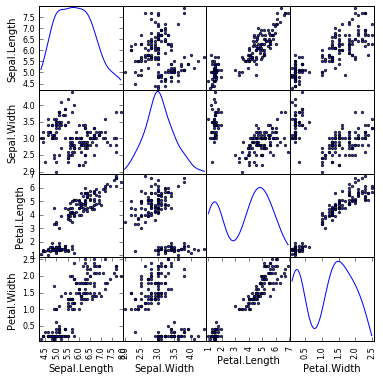

In [5]:
# 図やグラフを図示するためのライブラリをインポートする。
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.tools import plotting # 高度なプロットを行うツールのインポート
plotting.scatter_matrix(df[df.columns[1:5]], figsize=(6,6), alpha=0.8, diagonal='kde')   #全体像を眺める
plt.show()

### さていよいよ階層的クラスタリングの実行です。
* 階層的クラスタリングを実行するにあたって検討すべき事項は３つ。
    * 「特徴量の定義」
    * 「距離の定義」(metric)
    * 「リンケージ手法」(method)

ここでは、特徴量の定義は既に済んでいる（　df[df.columns[1:5]　）ものとし、距離の定義とリンケージ手法の選択を行って階層的クラスタリングを実行します。

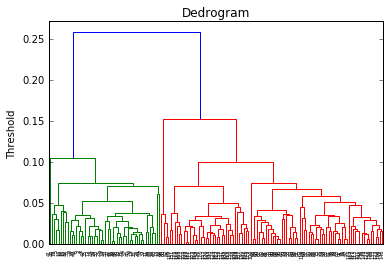

In [6]:
# metric は色々あるので、ケースバイケースでどれかひとつ好きなものを選ぶ。
# method も色々あるので、ケースバイケースでどれかひとつ好きなものを選ぶ。
from scipy.cluster.hierarchy import linkage, dendrogram
result1 = linkage(df.iloc[:, 1:5], 
                  metric = 'braycurtis', 
                  #metric = 'canberra', 
                  #metric = 'chebyshev', 
                  #metric = 'cityblock', 
                  #metric = 'correlation', 
                  #metric = 'cosine', 
                  #metric = 'euclidean', 
                  #metric = 'hamming', 
                  #metric = 'jaccard', 
                  #method= 'single')
                  method = 'average')
                  #method= 'complete')
                  #method='weighted')
dendrogram(result1)
plt.title("Dedrogram")
plt.ylabel("Threshold")
plt.show()

とりあえずこれで、デンドログラム（樹形図）は描けました。

### クラスタを得る

Threshold （閾値）を変えることでクラスタの数は変わります。どのくらいの閾値が適切か、どのくらいのクラスタ数が適切か、データの性質を理解した上でケースバイケースで検討しなければいけません。適切な閾値、あるいは適切なクラスタ数でクラスタを得る方法を作りましょう。

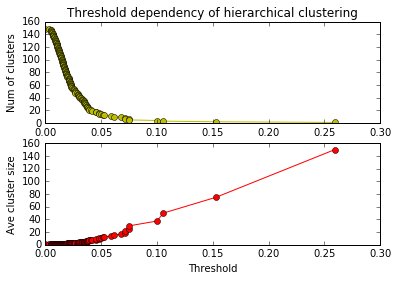

In [7]:
# Threshold を変えるとクラスタ数や平均クラスタサイズがどう変わるか調べる
import numpy as np
import matplotlib.pyplot as plt

n_clusters = len(df)
n_samples = len(df)
df1 = pd.DataFrame(result1)
x1 = []
y1 = []
x2 = []
y2 = []
for i in df1.index:
    n1 = int(df1.ix[i][0])
    n2 = int(df1.ix[i][1])
    val = df1.ix[i][2]
    n_clusters -= 1
    x1.append(val)
    x2.append(val)
    y1.append(n_clusters)
    y2.append(float(n_samples) / float(n_clusters))
        
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'yo-')
plt.title('Threshold dependency of hierarchical clustering')
plt.ylabel('Num of clusters')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, 'ro-')
plt.xlabel('Threshold')
plt.ylabel('Ave cluster size')
plt.show()

In [8]:
# 指定した thoreshold でクラスタを得る関数を作る
def get_cluster_by_threshold(result, threshold):
    output_clusters = []
    output_cluster_ids = []
    x_result, y_result = result.shape
    n_clusters = x_result + 1
    cluster_id = x_result + 1
    father_of = {}
    df1 = pd.DataFrame(result)
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    for i in df1.index:
        n1 = int(df1.ix[i][0])
        n2 = int(df1.ix[i][1])
        val = df1.ix[i][2]
        n_clusters -= 1
        if val < threshold:
            father_of[n1] = cluster_id
            father_of[n2] = cluster_id
            
        cluster_id += 1
    
    cluster_dict = {}
    for n in range(x_result + 1):
        if not father_of.has_key(n):
            output_clusters.append([n])
            continue
        
        n2 = n
        m = False
        while father_of.has_key(n2):
            m = father_of[n2]
            #print [n2, m]
            n2 = m
        
        if not cluster_dict.has_key(m):
            cluster_dict.update({m:[]})
        cluster_dict[m].append(n)
    
    output_clusters += cluster_dict.values()
    
    output_cluster_id = 0
    output_cluster_ids = [0] * (x_result + 1)
    for cluster in sorted(output_clusters):
        for i in cluster:
            output_cluster_ids[i] = output_cluster_id
        output_cluster_id += 1
            
    return output_cluster_ids

In [9]:
# 指定した thoreshold でクラスタを得る関数を使う。
print get_cluster_by_threshold(result1, 0.05)

[0, 1, 1, 1, 0, 2, 1, 0, 1, 1, 0, 0, 1, 3, 2, 2, 2, 0, 2, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 1, 1, 0, 2, 2, 1, 1, 0, 0, 1, 0, 0, 5, 1, 0, 2, 1, 0, 1, 0, 0, 6, 6, 6, 7, 6, 7, 6, 8, 6, 7, 8, 7, 9, 6, 7, 6, 7, 7, 9, 7, 10, 6, 10, 6, 6, 6, 6, 11, 6, 7, 7, 7, 7, 10, 7, 6, 6, 9, 7, 7, 7, 6, 7, 8, 7, 7, 7, 6, 8, 7, 11, 10, 12, 11, 11, 13, 14, 12, 12, 12, 11, 11, 11, 10, 10, 11, 11, 13, 13, 9, 11, 10, 13, 10, 11, 12, 10, 10, 11, 12, 12, 13, 11, 10, 10, 13, 11, 11, 10, 11, 11, 11, 10, 11, 11, 11, 10, 11, 11, 10]


In [10]:
# 指定したクラスタ数でクラスタを得る関数を作る。
def get_cluster_by_number(result, number):
    output_clusters = []
    x_result, y_result = result.shape
    n_clusters = x_result + 1
    cluster_id = x_result + 1
    father_of = {}
    df1 = pd.DataFrame(result)
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    for i in df1.index:
        n1 = int(df1.ix[i][0])
        n2 = int(df1.ix[i][1])
        val = df1.ix[i][2]
        n_clusters -= 1
        if n_clusters >= number:
            father_of[n1] = cluster_id
            father_of[n2] = cluster_id
            
        cluster_id += 1
    
    cluster_dict = {}
    for n in range(x_result + 1):
        if not father_of.has_key(n):
            output_clusters.append([n])
            continue
        
        n2 = n
        m = False
        while father_of.has_key(n2):
            m = father_of[n2]
            #print [n2, m]
            n2 = m
        
        if not cluster_dict.has_key(m):
            cluster_dict.update({m:[]})
        cluster_dict[m].append(n)
    
    output_clusters += cluster_dict.values()
            
    output_cluster_id = 0
    output_cluster_ids = [0] * (x_result + 1)
    for cluster in sorted(output_clusters):
        for i in cluster:
            output_cluster_ids[i] = output_cluster_id
        output_cluster_id += 1
            
    return output_cluster_ids

In [11]:
# 指定したクラスタ数でクラスタを得る関数を使う。
print get_cluster_by_number(result1, 5)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 4, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 2, 4, 2, 4, 2, 4, 4, 2, 2, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 2, 4, 4, 4, 2, 4, 4, 4, 2, 4, 4, 2]


以上で、階層的クラスタリングができるようになりました。でもこれだけでは、しっくり来る結果が得られたのかどうかよく分かりませんので、図示してみましょう。

### クラスタリング結果のマッピング
* クラスタリング結果を Scatter Matrix 上にマッピングします。
* 色は自分で決めることもできます（[総合実験４日目](http://nbviewer.jupyter.org/github/maskot1977/ipython_notebook/blob/master/%E7%B7%8F%E5%90%88%E5%AE%9F%E9%A8%93%EF%BC%94%E6%97%A5%E7%9B%AE.ipynb) 参照）が、色の数が増えると面倒なので次のように自動で決めることもできます。 [cmapのオプション](http://fififactory.com/wiki/index.php?plugin=attach&refer=FrontPage%2FPython%2FMatplotlib&openfile=mpl_cmap.png) を設定すればいろんな色の組み合わせで表現できます。

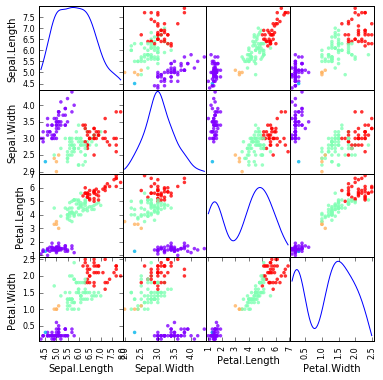

In [12]:
# Scatter Matrix に、クラスタリング結果をマッピング
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from pandas.tools import plotting # 高度なプロットを行うツールのインポート
plotting.scatter_matrix(df[df.columns[1:5]], figsize=(6,6), alpha=0.8, diagonal='kde', 
                        c=get_cluster_by_number(result1, 5), cmap=cm.rainbow, color=[], s=50)
plt.show()

* クラスタリング結果を、主成分分析のプロット上にマッピングします。

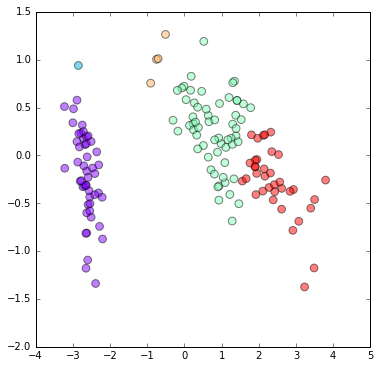

In [13]:
# 主成分分析のプロットに、クラスタリング結果をマッピング
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(df[df.columns[1:5]])
feature = pca.transform(df[df.columns[1:5]])
plt.figure(figsize=(6, 6))
plt.scatter(feature[:, 0], feature[:, 1], c=get_cluster_by_number(result1, 5), s=60, alpha=0.5,
            cmap=plt.cm.rainbow)
plt.show()

### もうちょっと詳しく、流れを理解したい
以上で、階層的クラスタリングと、クラスタリング結果のマッピングまでできるようになりました。ここから先は、やらなくても良いと言えばやらなくても良いところです。階層的クラスタリングをするときに、何が起こっているのか少しだけ詳しく見ながら進めると次のようになります。

__距離行列生成__

In [14]:
# 距離といっても色んな距離があるので、どれか選ぶ。
import scipy.spatial.distance as distance
n_samples = len(df)
dMatrix = np.zeros([n_samples, n_samples])
for i in range(n_samples):
    for j in range(n_samples):
        dMatrix[i, j] = distance.braycurtis(df.ix[i, 1:5], df.ix[j, 1:5]) # braycurtis　距離
        #dMatrix[i, j] = distance.canberra(df.ix[i, 1:5], df.ix[j, 1:5]) # canberra　距離
        #dMatrix[i, j] = distance.chebyshev(df.ix[i, 1:5], df.ix[j, 1:5])  # chebyshev　距離
        #dMatrix[i, j] = distance.cityblock(df.ix[i, 1:5], df.ix[j, 1:5])  # cityblock　距離
        #dMatrix[i, j] = distance.correlation(df.ix[i, 1:5], df.ix[j, 1:5])  # correlation　距離
        #dMatrix[i, j] = distance.cosine(df.ix[i, 1:5], df.ix[j, 1:5])  # cosine　距離
        #dMatrix[i, j] = distance.euclidean(df.ix[i, 1:5], df.ix[j, 1:5])  # euclidean　距離
        #dMatrix[i, j] = distance.hamming(df.ix[i, 1:5], df.ix[j, 1:5])  # hamming　距離
        #dMatrix[i, j] = distance.jaccard(df.ix[i, 1:5], df.ix[j, 1:5])  # jaccard　距離

In [15]:
#距離行列の中身を見る
pd.DataFrame(dMatrix).head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0.000000,0.035533,0.040816,0.051020,0.009804,0.055556,0.035176,0.014778,0.068063,0.040404,...,0.300000,0.289855,0.268482,0.302817,0.295775,0.291971,0.289575,0.278810,0.265455,0.253846
1,0.035533,0.000000,0.026455,0.026455,0.035533,0.090909,0.041667,0.030612,0.032609,0.015707,...,0.304029,0.293680,0.264000,0.314079,0.314079,0.288390,0.285714,0.274809,0.291045,0.249012
2,0.040816,0.026455,0.000000,0.021277,0.040816,0.096154,0.026178,0.035897,0.038251,0.031579,...,0.316176,0.305970,0.285141,0.318841,0.318841,0.308271,0.306773,0.295019,0.295880,0.269841
3,0.051020,0.026455,0.021277,0.000000,0.051020,0.096154,0.026178,0.035897,0.027322,0.021053,...,0.308824,0.298507,0.277108,0.318841,0.318841,0.300752,0.298805,0.287356,0.295880,0.261905
4,0.009804,0.035533,0.040816,0.051020,0.000000,0.055556,0.035176,0.014778,0.068063,0.040404,...,0.307143,0.297101,0.276265,0.309859,0.302817,0.299270,0.297297,0.286245,0.272727,0.261538


__距離行列を距離ベクトルに変換する__

In [16]:
# 距離行列を距離ベクトルに変換する
dArray = distance.squareform(dMatrix)

In [17]:
# 距離ベクトルを確認する
pd.DataFrame(dArray).T

,0,1,2,3,4,5,6,7,8,9,...,11165,11166,11167,11168,11169,11170,11171,11172,11173,11174
0,0.035533,0.040816,0.05102,0.009804,0.055556,0.035176,0.014778,0.068063,0.040404,0.028571,...,0.045593,0.014749,0.031884,0.042424,0.030864,0.054545,0.034921,0.035294,0.027692,0.045317


__階層的クラスタリング__

In [18]:
#クラスタリングする。リンケージ手法にもいろいろあるので、どれか選ぶ。
result = linkage(dArray, method = 'average')
#result = linkage(dArray, method = 'complete')
#result = linkage(dArray, method = 'single')
#result = linkage(dArray, method = 'weighted')

__デンドログラムの描画__

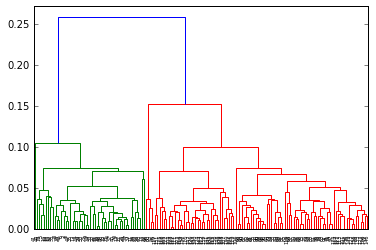

In [19]:
# デンドログラムの描画
dend = dendrogram(result)

----------
## 課題
以下の課題を解いてください。
* __課題1__:  上記のクラスタリングで、「距離の定義」(metric)と「リンケージ手法」(method)を変えるとデンドログラムがどのように変わるか確認してください。
* __課題2__: 同様に、クラスタ数を２〜６に変えるとマッピング結果がどのように変わるか確認してください。

お疲れ様でした。他の教材は随時下記に追加予定です。→ [IPython Notebook](https://sites.google.com/site/masaakikotera/8-python/8-2-ipython-notebook)